# 특징점 검출과 매칭  
  
1. 코너 검출  
  
코너의 특징  
• 평탄한 영역(flat) & 에지(edge) 영역은 고유한 위치를 찾기 어려움  
• 코너(corner)는 변별력이 높은 편이며, 영상의 이동, 회전 변환에 강인함  
  
<코너 검출 방법>  
   
해리스(Harris): 
영상 내부 작은 영역이 모든 방향에 대해 변화가 큰 경우 코너로 규정  
코너 응답 함수 R을 반환 → R(x,y)가 충분히 크면 코너로 구분  
cv2.cornerHarris() 함수 사용  
  
추적하기 좋은 특징(Good Features to Track):  
해리스 코너 검출 방법을 기반으로 향상된 방법  
비최대 억제 수행  
코너 품질 함수를 정의 → 가장 값이 큰 순서대로 정렬하여 반환  
cv2.goodFeaturesToTrack() 함수 사용  
  
FAST(Features from Accelerated Segment Test):  
주변 16개 픽셀 값 크기를 분석  
기준 픽셀(p)보다 충분히 밝거나(>p+t) 또는 충분히 어두운(<p-t)  
픽셀이 n개 연속으로 나타나면 코너로 인식 (n은 보통 9)  
해리스, GFTT 방법보다 매우 빠르게 동작  
  
<해리스 코너 응답 함수 계산>  
cv2.cornerHarris(src, blockSize, ksize, k, borderType=None) -> dst  
  
src:입력 단일채널 8비트 또는 실수형 영상  
blockSize:코너 응답 함수 계산에서 고려할 이웃 픽셀 크기. 보통 2-5  
ksize:(미분을 위한) 소벨 연산자를 위한 커널 크기. 보통 3  
k:해리스 코너 검출 상수 (보통 0.04~0.06)  
borderType: 가장자리 픽셀 확장 방식. 기본값은 cv2.BORDER_DEFAULT  
dst:해리스 코너 응답 계수. src와 같은 크기의 행렬(numpy.ndarray). 
dtype=numpy.float32  
  
<추적하기 좋은 특징 코너 검출>  
cv2.goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance,
mask=None, blockSize=None, useHarrisDetector=None, k=None) -> corners  
  
image:8비트 또는 32비트 실수, 단일채널 영상  
maxCorners: 최대 코너 개수. maxCorners <=0 이면 무제한  
qualityLevel: 코너점 결정을 위한 값. 보통 0.01 ~ 0.1  
minDistance: 코너점 사이의 최소 거리  
corners:검출된 코너점 좌표. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32.  
mask:마스크 영상  
blockSize:코너 검출을 위한 블록 크기. 기본값은 3  
useHarrisDetector: 해리스 코너 방법 사용 여부. 기본값은 False  
k:해리스 코너 검출 시 사용할 k 값  
  
<FAST 코너 검출>  
cv2.FastFeatureDetector_create(threshold=None, nonmaxSuppression=None,
type=None) -> retval  
cv2.FastFeatureDetector.detect(image) -> keypoints  
threshold:중심 픽셀 값과 주변 픽셀 값과의 차이 임계값. 기본값은 10  
nonmaxSuppression: 비최대 억제 수행 여부. 기본값은 True  
type:코너 검출 방법. 기본값은 cv2.FAST_FEATURE_DETECTOR_TYPE_9_16  
retval:FastFeatureDetector 객체  
image:(입력) 그레이스케일 영상  
keypoints:(출력) 검출된 코너점 정보. cv2.KeyPoint 객체를 담은 리스트.
cv2.KeyPoint의 pt 멤버를 이용하여 코너 좌표 추출.pt[0]은 x좌표, pt[1]은 y좌표  
  
코너 검출 반복성 비교  
• FAST 방법의 반복 검출률이 대체로 높음  
• FAST 방법은 노이즈에 민감함  

In [1]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/building.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

tm = cv2.TickMeter()#연산 시간 측정 객체

# GFTT
tm.start()#시간 측정 시작

corners = cv2.goodFeaturesToTrack(src, 400, 0.01, 10)#(이미지, 코너검출최대수, 코너결정상수, 코너사이최소거리)

tm.stop()#시간 측정 종료
print('GFTT: {}ms.'.format(tm.getTimeMilli()))

dst1 = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

if corners is not None:
    for i in range(corners.shape[0]):
        pt = (int(corners[i, 0, 0]), int(corners[i, 0, 1]))
        cv2.circle(dst1, pt, 5, (0, 0, 255), 2)

# FAST
tm.reset()
tm.start()

fast = cv2.FastFeatureDetector_create(60)#(임계값)
keypoints = fast.detect(src)

tm.stop()
print('FAST: {}ms.'.format(tm.getTimeMilli()))

dst2 = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv2.circle(dst2, pt, 5, (0, 0, 255), 2)

cv2.imshow('src', src)
cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)
cv2.waitKey()

cv2.destroyAllWindows()


GFTT: 244.8061ms.
FAST: 61.250899999999994ms.


2. 이미지 피라미드  
이미지를 확대, 축소 샘플링.(4배, 1/4배 등)  
동작: upsize(zoom in) / downsize(zoom out)  
  
*image pyramid: 하나의 원본 이미지에 반복적으로 다운 샘플링한 이미지 모음   
  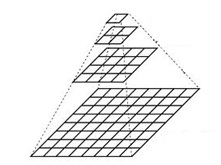  
  [gaussian pyramid]  
  
1)	Gaussian Pyramid: 이미지 다운 샘플링. 모든 레이어는 아래에서 위로 번호가 매겨짐(i+1). 짝수번째 행과 열을 제거함으로 축소.(1, 1/4, 1/8 ...)  
  
2)	Laplacian Pyramid: 위 가우시안 피라미드 아래층의 이미지로 업 샘플링된 이미지 재구성(해상도 낮음)  
  
<Gaussian Pyramid 예>  
img = cv2.imread('k.jpg')  
lower_reso = cv2.pyrDown(img) # 원본 이미지의 1/4 사이즈  
higher_reso = cv2.pyrUp(img) #원본 이미지의 4배 사이즈  
  
<Laplacian Pyramid 예>  
가우시안 피라미드로 이미지를 축소했다가 다시 확대하면 이 과정에서 행이나 열이 	소실된다. 이렇게 생성된 이미지를 원본 이미지 크기로 변경한 뒤 원본 이미지에서 	피라미드 이미지의 차(-)를 계산하면 이미지 윤곽이 도출됨  


In [2]:
import cv2

img = cv2.imread('img/building.jpg')


s = cv2.pyrDown(img) # 원본 이미지의 1/4 사이즈
l = cv2.pyrUp(s) #원본 이미지의 4배 사이즈

h, w, c = img.shape
l2 = cv2.resize(l, (w, h))
res = cv2.subtract(img, l2)

cv2.imshow('img', res)
cv2.waitKey(0)
cv2.destroyAllWindows()


3. 특징점 검출  
  
Harris, GFTT, FAST 코너의 문제점  
• 이동, 회전 변환에 강인  
• 크기 변환에 취약  
=> 다양한 크기 관점에서 특징 검출 필요  
  
크기 불변 특징점 검출 방법  
• SIFT, KAZE, AKAZE, ORB 등 다양한 특징점 검출 방법에서 스케일 스페이스(scale-space), 이미지 피라미드(image pyramid)를 구성하여 크기 불변 특징점을 검출  
  
특징점 검출 알고리즘 객체 생성  
cv2.KAZE_create() -> retval  
cv2.AKAZE_create() -> retval  
cv2.ORB_create() -> retval  
cv2.xfeatures2d.SIFT_create() -> retval  
...  
retval:각 특징점 검출 알고리즘 객체  
  
특징점 검출 함수  
cv2.Feature2D.detect(image, mask=None) -> keypoints  
  
image:입력 영상  
mask:마스크 영상  
keypoints:검출된 특징점 정보. cv2.KeyPoint 객체의 리스트  
  
검출된 특징점 그리기 함수  
cv2.drawKeypoints(image, keypoints, color=None, flags=None)  
-> outImage  
  
image:입력 영상  
keypoints:검출된 특징점 정보. cv2.KeyPoint 객체의 리스트  
color:특징점 표현 색상. 기본값은 (-1, -1, -1, -1)이며, 이 경우 임의의 색상으로 표현  
flags:특징점 표현 방법  
<flags 종류>  
cv2.DRAW_MATCHES_FLAGS_DEFAULT:특징점 위치만을 표현하는 작은 크기의 원  
cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: 
특징점의 크기와 방향을 반영한 원  
  
outImage:출력 영상  


In [3]:
import sys
import numpy as np
import cv2


# 영상 불러오기
src1 = cv2.imread('img/graf1.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('img/graf3.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

# 특징점 검출
kp1 = feature.detect(src1)
kp2 = feature.detect(src2)

print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))

# 검출된 특징점 출력 영상 생성
dst1 = cv2.drawKeypoints(src1, kp1, None,
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dst2 = cv2.drawKeypoints(src2, kp2, None,
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)
cv2.waitKey()
cv2.destroyAllWindows()


# of kp1: 3159
# of kp2: 3625


4. 특징점 기술  
  
기술자(Descriptor, feature vector)  
• 특징점 근방의 부분 영상을 표현하는 실수 또는 이진 벡터  
• OpenCV에서는 2차원 행렬(numpy.ndarray)로 표현  
행 개수: 특징점 개수  
열 개수: 특징점 기술자 알고리즘에 의해 정의됨  
실수 기술자: numpy.float32  
이진 기술자: numpy.uint8  
  
실수 기술자  
• 주로 특징점 부근 부분 영상의 방향 히스토그램을 사용  
=>특징점 근방 부분 영상의 주 방향 성분을 계산하여 보정  
=>보정된 사각형 영역을 4 * 4 구역으로 분할 → 각 구역에서 8방향 히스토그램을 구함  
=>4 * 4 * 8 = 128 차원의 실수 벡터(알고리즘마다 다름)  
• 보통 numpy.float32 자료형을 사용하여 실수 정보를 저장하는 방식  
• 실수 기술자를 사용하는 알고리즘: SIFT, SURF, KAZE 등  
• 실수 기술자는 보통 L2 노름(L2 norm)을 사용하여 유사도를 판단  
  
이진 기술자(Binary descriptor)  
• 이진 테스트(Binary test)를 이용하여 부분 영상의 특징을 기술  
• 보통 numpy.uint8 자료형을 사용하여 비트 단위로 영상 특징 정보를 저장하는 방식  
• 이진 기술자를 사용하는 알고리즘: AKAZE, ORB, BRIEF 등  
• 이진 기술자는 해밍 거리(Hamming distance)를 사용하여 유사도를 판단  
=> 해밍 거리(Hamming distance)는 곱집합 위에 정의되는 거리 함수이다. 대략, 같은 길이의 두 문자열에서, 같은 위치에서 서로 다른 기호들이 몇 개인지를 센다.
  
특징점 기술자 계산 함수  
cv2.Feature2D.compute(image, keypoints, descriptors=None)
-> keypoints, descriptors  
  
image:입력 영상  
keypoints:검출된 특징점 정보. cv2.KeyPoint 객체의 리스트  
descriptors:특징점 기술자 행렬  
  
특징점 검출 및 기술자 계산 함수  
cv2.Feature2D.detectAndCompute(image, mask=None, descriptors=None)
-> keypoints, descriptors  
  
image:입력 영상  
mask:마스크 영상  
keypoints:검출된 특징점 정보. cv2.KeyPoint 객체의 리스트  
descriptors:특징점 기술자 행렬  


In [4]:
import sys
import numpy as np
import cv2


# 영상 불러오기
src1 = cv2.imread('img/graf1.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('img/graf3.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

# 특징점 검출 및 기술자 계산
kp1 = feature.detect(src1)
_, desc1 = feature.compute(src1, kp1)

kp2, desc2 = feature.detectAndCompute(src2, None)

print('desc1.shape:', desc1.shape)
print('desc1.dtype:', desc1.dtype)
print('desc2.shape:', desc2.shape)
print('desc2.dtype:', desc2.dtype)

# 검출된 특징점 출력 영상 생성
dst1 = cv2.drawKeypoints(src1, kp1, None,
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dst2 = cv2.drawKeypoints(src2, kp2, None,
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)
cv2.waitKey()
cv2.destroyAllWindows()


desc1.shape: (3159, 64)
desc1.dtype: float32
desc2.shape: (3625, 64)
desc2.dtype: float32


5. 특징점 매칭  
  
특징점 매칭 (feature point matching)  
• 두 영상에서 추출한 특징점 기술자를 비교하여 서로 유사한 기술자를 찾는 작업  
  
특징 벡터 유사도 측정 방법  
• 실수 특징 벡터: L2 노름(L2 norm) 사용  
• 이진 특징 벡터: 해밍 거리(hamming distance) 사용  
  
특징점 매칭 알고리즘 객체 생성  
cv2.BFMatcher_create(, normType=None, crossCheck=None) -> retval  
  
normType: 특징점 기술자 거리 계산 방식 지정. 기본값은 cv2.NORM_L2  
     => cv2.NORM_L1: L1 노름(L1 norm) 사용  
        cv2.NORM_L2: L2 노름(L2 norm) 사용  
        cv2.NORM_HAMMING: 해밍 거리 사용  
        cv2.NORM_HAMMING2: 두 비트를 한 단위로 취급하여 해밍 거리 계산  
crossCheck: 이 값이 True이면 양방향 매칭 결과가 같은 경우만 반환함. 기본값은 False  
  
특징점 검출 알고리즘 객체 생성  
cv2.DescriptorMatcher.match(queryDescriptors, trainDescriptors, mask=None)-> matches   
  
queryDescriptors: (기준 영상 특징점) 질의 기술자 행렬  
trainDescriptors: (대상 영상 특징점) 학습 기술자 행렬
mask: 매칭 진행 여부를 지정하는 행렬 마스크  
matches: 매칭 결과. cv2.DMatch 객체의 리스트  
  
특징점 검출 알고리즘 객체 생성  
cv2.DescriptorMatcher.knnmatch(queryDescriptors, trainDescriptors, k,
mask=None, compactResult=None) -> matches  
  
queryDescriptors: (기준 영상 특징점) 질의 기술자 행렬  
trainDescriptors: (대상 영상 특징점) 학습 기술자 행렬  
k: 질의 기술자에 대해 검출할 매칭 개수  
mask: 매칭 수행 여부를 지정하는 행렬 마스크  
compactResult: mask가 None이 아닐 때 사용되는 파라미터. 기본값은 False이며, 이 경우 결과 matches는 기준 영상 특징점과 같은 크기를 가짐.  
matches: 매칭 결과. cv2.DMatch 객체의 리스트의 리스트.  
  
특징점 매칭 결과 영상 생성  
cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches1to2, 
matchColor=None, singlePointColor=None, matchesMask=None,
flags=None) -> outImg  
  
img1, keypoints1: 기준 영상과 기준 영상에서 추출한 특징점 정보  
img2, keypoints2: 대상 영상과 대상 영상에서 추출한 특징점 정보  
matches1to2: 매칭 정보. cv2.DMatch의 리스트  
matchColor: 매칭된 특징점과 직선 색상  
singlePointColor: 매칭되지 않은 특징점 색상  
matchesMask: 매칭 정보를 선택하여 그릴 때 사용할 마스크  
flags: 매칭 정보 그리기 방법. 기본값은 cv2.DRAW_MATCHES_FLAGS_DEFAULT  
outImg: 출력 영상  


In [5]:
import sys
import numpy as np
import cv2


# 영상 불러오기
src1 = cv2.imread('img/graf1.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('img/graf3.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

# 특징점 검출 및 기술자 계산
kp1, desc1 = feature.detectAndCompute(src1, None)
kp2, desc2 = feature.detectAndCompute(src2, None)

# 특징점 매칭
matcher = cv2.BFMatcher_create()
#matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = matcher.match(desc1, desc2)

print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))
print('# of matches:', len(matches))

# 특징점 매칭 결과 영상 생성
dst = cv2.drawMatches(src1, kp1, src2, kp2, matches, None)

cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


# of kp1: 3159
# of kp2: 3625
# of matches: 3159


좋은 매칭 선별 방법-1  
• 가장 좋은 매칭 결과에서 distance 값이 작은 것 N개를 사용  
• cv2.DMatch.distance 값을 기준으로 정렬 후 상위 N개 선택  
  
<예제>  
#특징점 매칭  
matcher = cv2.BFMatcher_create()  
matches = matcher.match(desc1, desc2)  
  
#좋은 매칭 결과 선별  
matches = sorted(matches, key=lambda x: x.distance)  
good_matches = matches[:80]  
  
#특징점 매칭 결과 영상 생성  
dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None)  
  
좋은 매칭 선별 방법-2  
• 가장 좋은 매칭 결과의 distance 값과 두 번째로 좋은 매칭 결과의 distance 값의 비율을 계산  
• 이 비율이 임계값(예 0.7)보다 작으면 선택  
  
<예제>  
#특징점 매칭  
matcher = cv2.BFMatcher_create()  
matches = matcher.knnMatch(desc1, desc2, 2)  
  
#좋은 매칭 결과 선별  
good_matches = []  
for m in matches:  
   if m[0].distance / m[1].distance < 0.7:  
      good_matches.append(m[0])  
  
#특징점 매칭 결과 영상 생성  
dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None)  

In [5]:
import sys
import numpy as np
import cv2


# 영상 불러오기
src1 = cv2.imread('img/graf1.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('img/graf3.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

# 특징점 검출 및 기술자 계산
kp1, desc1 = feature.detectAndCompute(src1, None)
kp2, desc2 = feature.detectAndCompute(src2, None)

# 특징점 매칭
matcher = cv2.BFMatcher_create()
#matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = matcher.match(desc1, desc2)

# 좋은 매칭 결과 선별
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:80]

print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))
print('# of matches:', len(matches))
print('# of good_matches:', len(good_matches))

# 특징점 매칭 결과 영상 생성
dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None)

cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


# of kp1: 3159
# of kp2: 3625
# of matches: 3159
# of good_matches: 80


In [6]:
import sys
import numpy as np
import cv2


# 영상 불러오기
src1 = cv2.imread('img/graf1.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('img/graf3.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

# 특징점 검출 및 기술자 계산
kp1, desc1 = feature.detectAndCompute(src1, None)
kp2, desc2 = feature.detectAndCompute(src2, None)

# 특징점 매칭
matcher = cv2.BFMatcher_create()
#matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = matcher.knnMatch(desc1, desc2, 2)

# 좋은 매칭 결과 선별
good_matches = []
for m in matches:
    if m[0].distance / m[1].distance < 0.7:
        good_matches.append(m[0])

print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))
print('# of matches:', len(matches))
print('# of good_matches:', len(good_matches))

# 특징점 매칭 결과 영상 생성
dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None)

cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


# of kp1: 3159
# of kp2: 3625
# of matches: 3159
# of good_matches: 384


6. 호모그래피  
  
호모그래피(Homography)란?  
• 두 평면 사이의 투시 변환(Perspective transform)  
• 8DOF(Depth of Field) : 최소 4개의 대응점 좌표가 필요  
  
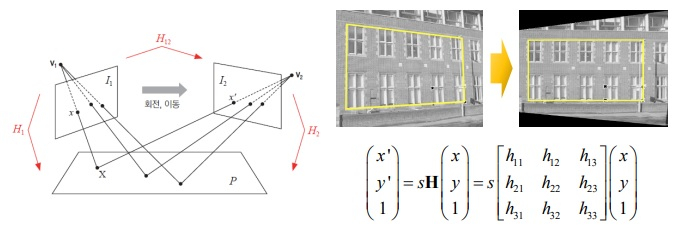  
  
호모그래피 계산 함수  
cv2.findHomography(srcPoints, dstPoints, method=None, 
ransacReprojThreshold=None, mask=None, maxIters=None,
confidence=None) -> retval, mask  
  
srcPoints: 입력 점 좌표. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32  
dstPoints: 결과 점 좌표. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32  
method: 호모그래피 행렬 계산 방법. 0, LMEDS, RANSAC, RHO 중 선택.
기본값은 0이며, 이상치가 있을 경우 RANSAC, RHO 방법 권장  
ransacReprojThreshold: RANSAC 재투영 에러 허용치. 기본값은 3  
maxIters: RANSAC 최대 반복 횟수. 기본값은 2000  
retval: 호모그래피 행렬. numpy.ndarray. shape=(3, 3). dtype=numpy.float32  
mask: 출력 마스크 행렬. RANSAC, RHO 방법 사용 시 Inlier로 사용된
점들을 1로 표시한 행렬. numpy.ndarray. shape=(N, 1), dtype=uint8  


In [12]:
import sys
import numpy as np
import cv2


# 영상 불러오기
src1 = cv2.imread('img/graf1.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('img/graf3.png', cv2.IMREAD_GRAYSCALE)
#src1 = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)
#src2 = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)

if src1 is None or src2 is None:
    print('Image load failed!')
    sys.exit()

# 특징점 알고리즘 객체 생성 (KAZE, AKAZE, ORB 등)
feature = cv2.KAZE_create()
#feature = cv2.AKAZE_create()
#feature = cv2.ORB_create()

# 특징점 검출 및 기술자 계산
kp1, desc1 = feature.detectAndCompute(src1, None)
kp2, desc2 = feature.detectAndCompute(src2, None)

# 특징점 매칭
matcher = cv2.BFMatcher_create()
#matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = matcher.match(desc1, desc2)

# 좋은 매칭 결과 선별
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:80]

print('# of kp1:', len(kp1))
print('# of kp2:', len(kp2))
print('# of matches:', len(matches))
print('# of good_matches:', len(good_matches))

# 호모그래피 계산
pts1 = np.array([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
pts2 = np.array([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)

#변환 행렬 생성
H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)

# 호모그래피를 이용하여 기준 영상 영역 표시
dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

(h, w) = src1.shape[:2]
#src1이미지의 4꼭지점 좌표 계산
corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2).astype(np.float32)

#위 네 점의 투영 좌표 계산
corners2 = cv2.perspectiveTransform(corners1, H)

#변환 좌표 x축에 800 더해줌. 이미지 2개를 함께 보여주므로 src2 이미지의 x축은 src1의 가로 길이만큼 오른쪽으로 이동
corners2 = corners2 + np.float32([w, 0])

cv2.polylines(dst, [np.int32(corners2)], True, (0, 255, 0), 2, cv2.LINE_AA)

cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


# of kp1: 3159
# of kp2: 3625
# of matches: 3159
# of good_matches: 80


7. 이미지 스티칭  
  
이미지 스티칭(Image Stitching)이란?  
• 동일 장면의 사진을 자연스럽게(seamless) 붙여서 한 장의 사진으로 만드는 기술  
• 사진 이어 붙이기, 파노라마 영상(Panorama image)  
  
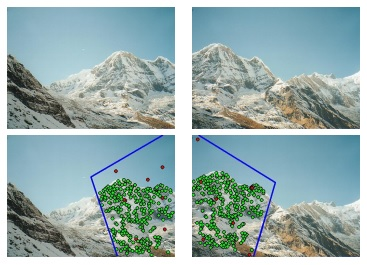  
  
이미지 스티칭 객체 생성  
cv2.Stitcher_create(, mode=None) -> retval  
  
mode: 스티칭 모드. cv2.PANORAMA 또는 cv2.SCANS 중 하나 선택.
기본값은 cv2.PANORAMA  
retval: cv2.Stitcher 클래스 객체  
  
이미지 스티칭 함수  
cv2.Stitcher.stitch(images, pano=None) -> retval, pano  
  
images: 입력 영상 리스트  
retval: 성공하면 cv2.Stitcher_OK  
pano: 파노라마 영상  


In [10]:
import sys
import numpy as np
import cv2


img_names = ['img/img1.jpg', 'img/img2.jpg', 'img/img3.jpg']

imgs = []
for name in img_names:
    img = cv2.imread(name)

    if img is None:
        print('Image load failed!')
        sys.exit()

    imgs.append(img)

stitcher = cv2.Stitcher_create()
status, dst = stitcher.stitch(imgs)

if status != cv2.Stitcher_OK:
    print('Stitch failed!')
    sys.exit()

cv2.imwrite('output.jpg', dst)

cv2.namedWindow('dst', cv2.WINDOW_NORMAL)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()
